### Environment: base_path variable includes the local path to the cloned github repository

In [1]:
base_path = "d:/Projects-my/ml/Ml-hse-final"
classpath = base_path + "/ada-boost-implementations/code-python/adaboost_java/lib-adaboost.jar"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef\
, precision_score, recall_score, f1_score
import time
import math

In [3]:
import os
import sys
sys.path.append(base_path + "/ada-boost-implementations/code-python/")
from ada_boost_standard_v1 import AdaBoostStandardClassifier_v1;
from ada_boost_linear_v1 import AdaBoostLinear_v1;
from generation_utils import make_classification_normal, make_separable_labels;
from adaboost_java.ada_boost_java_v1 import AdaBoostJavaClassifier_v1;
from rademacher_utils import calc_rademacher_biclassifiers, calc_margin_loss

In [4]:
def draw_data_by_coord01(x_data, y_data, v_normal):
    plt.scatter(x_data[:, 0], x_data[:, 1], marker="o", c=y_data, s=10, edgecolor="k")
    y2_coord = -2*v_normal[0]/(v_normal[1] + 1e-10)
    plt.plot([-2,2], [-y2_coord, y2_coord], color='r')
    plt.show()


In [5]:
def params2classifiers(samples, repeat_count = 5, test_size = 1/3):
    idxs, cnt = np.arange(0, 100, 5), 0
    lossesL, lossesJ, rademachers, X_trains, y_trains = [], [], [], [], []
    marginsL, marginsJ, errorsL, errorsJ = [], [], [], []
    while cnt < repeat_count:
        try:
            X_data, _ = make_classification(n_samples=samples, n_features=5, n_informative=2
                                    , n_redundant=2, n_clusters_per_class=2, shuffle=False)
            X_data, y_data, _ = make_separable_labels(X_data, rho=0.1)

            X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(X_data, y_data, test_size=test_size)
            #ada boost
            clf2000J = AdaBoostJavaClassifier_v1(path=classpath)
            result = clf2000J.fit(X_train2000, y_train2000, n_estimators=250)
            separated = accuracy_score(y_train2000, clf2000J.predict(X_train2000))
            if separated < 1:
                raise Exception("Failed to separate in ada boost algorithm, accuracy = {}".format(separated))
            #linear
            clf2000L = AdaBoostLinear_v1()
            _, _, _ = clf2000L.fit(X_train2000, y_train2000, allow_nonseparable=True)
            separated = accuracy_score(y_train2000, clf2000L.predict(X_train2000))
            if separated < 1:
                raise Exception("Failed to separate in linear algorithm, accuracy = {}".format(separated))
            #Collecting params
            X_trains.append(X_train2000)
            y_trains.append(y_train2000)
            rademachers.append(clf2000J.calc_rademacher_biclassifiers(X_train2000, 1000))
            marginsL.append(clf2000L.get_margin())
            marginsJ.append(clf2000J.get_margin_l1(X_train2000))
            errorsL.append(1 - accuracy_score(y_test2000, clf2000L.predict(X_test2000)))
            errorsJ.append(1 - accuracy_score(y_test2000, clf2000J.predict(X_test2000)))
            #Margin losses
            valuesL, valuesJ = {}, {}
            for idx, rho_var in zip(idxs, idxs/100):
                #index = int(rho_var*100)
                valuesL[idx] = calc_margin_loss(X_train2000, y_train2000, clf2000L.predict_raw, rho_var)
                valuesJ[idx] = clf2000J.calc_margin_loss(X_train2000, y_train2000, rho_var)
            lossesL.append(valuesL)
            lossesJ.append(valuesJ)
            
            cnt += 1
        except Exception as ex:
            print("Error diring calculation:", ex.args)
            print("Iteration skipped")
        
    return lossesL, lossesJ, rademachers, X_trains, y_trains, marginsL, marginsJ, errorsL, errorsJ


In [6]:
def params2classifiers_for_data(X_data, y_data, repeat_count = 5, test_size = 1/3):
    #rho_vars, cnt = np.arange(0.00, 1, 0.05), 0
    idxs, cnt = np.arange(0, 100, 5), 0
    lossesL, lossesJ, rademachers, X_trains, y_trains = [], [], [], [], []
    marginsL, marginsJ, errorsL, errorsJ = [], [], [], []
    while cnt < repeat_count:
        try:
            X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(X_data, y_data, test_size=test_size)
            #ada boost
            clf2000J = AdaBoostJavaClassifier_v1(path=classpath)
            result = clf2000J.fit(X_train2000, y_train2000, n_estimators=250)
            separated = accuracy_score(y_train2000, clf2000J.predict(X_train2000))
            if separated < 1:
                raise Exception("Failed to separate in ada boost algorithm, accuracy = {}".format(separated))
            #linear
            clf2000L = AdaBoostLinear_v1()
            _, _, _ = clf2000L.fit(X_train2000, y_train2000, allow_nonseparable=True)
            separated = accuracy_score(y_train2000, clf2000L.predict(X_train2000))
            if separated < 1:
                raise Exception("Failed to separate in linear algorithm, accuracy = {}".format(separated))
            #Collecting params
            X_trains.append(X_train2000)
            y_trains.append(y_train2000)
            rademachers.append(clf2000J.calc_rademacher_biclassifiers(X_train2000, 1000))
            marginsL.append(clf2000L.get_margin())
            marginsJ.append(clf2000J.get_margin_l1(X_train2000))
            errorsL.append(1 - accuracy_score(y_test2000, clf2000L.predict(X_test2000)))
            errorsJ.append(1 - accuracy_score(y_test2000, clf2000J.predict(X_test2000)))
            #Margin losses
            valuesL, valuesJ = {}, {}
            for idx, rho_var in zip(idxs, idxs/100):
                #index = int(rho_var*100)
                valuesL[idx] = calc_margin_loss(X_train2000, y_train2000, clf2000L.predict_raw, rho_var)
                valuesJ[idx] = clf2000J.calc_margin_loss(X_train2000, y_train2000, rho_var)
            lossesL.append(valuesL)
            lossesJ.append(valuesJ)
            cnt += 1
        except Exception as ex:
            print("Error diring calculation:", ex.args)
            print("Iteration skipped")
            
    return lossesL, lossesJ, rademachers, X_trains, y_trains, marginsL, marginsJ, errorsL, errorsJ


In [21]:
def draw2classifiers_error_bound(X_trains, y_trains, lossesL, lossesJ, rademachers, idxs):

    options = [
        ('r', 'Generalisation error estimation - linear algorithm'),
        ('g', 'Generalisation error estimation - ada-boost algorithm')
    ]
    delta = 0.05
    avgL, avgJ = np.zeros(len(idxs)), np.zeros(len(idxs))
    rho_vars = idxs/100

    plt.ylabel('Generalisation error estimation')
    plt.xlabel('Rho value')

    for X_train, y_train, lsL, lsJ, rdm in zip(X_trains, y_trains, lossesL, lossesJ, rademachers):
        sample_size = X_train.shape[0]
        valuesL, valuesJ = [], []
        for idx, rho_var in tqdm(zip(idxs, idxs/100), total=len(idxs)):
            #index = int(rho_var*100)
            valueTail = 2*rdm/rho_var + 3*math.sqrt(math.log(2/delta)/(2*sample_size))
            valuesL.append(lsL[idx] + valueTail)
            valuesJ.append(lsJ[idx] + valueTail)

        avgL += np.array(valuesL)
        avgJ += np.array(valuesJ)
        plt.plot(rho_vars, valuesL, options[0][0] + ':', alpha=0.1)
        plt.plot(rho_vars, valuesJ, options[1][0] + ':', alpha=0.1)

    plt.plot(rho_vars, avgL / (1. * len(rademachers)), options[0][0], linewidth=1.0, label=options[0][1])
    plt.plot(rho_vars, avgJ / (1. * len(rademachers)), options[1][0], linewidth=1.0, label=options[1][1])
    dummy = plt.legend(bbox_to_anchor=(0.4, 1))

In [27]:
def draw2classifiers_margin_loss(X_trains, y_trains, lossesL, lossesJ, idxs):
    options = [
        ('r', 'Empirical margin loss - linear algorithm'),
        ('g', 'Empirical margin loss - ada-boost algorithm')
    ]

    rho_vars = idxs/100
    avgL, avgJ = np.zeros(len(rho_vars)), np.zeros(len(rho_vars))

    plt.ylabel('Empirical margin loss')
    plt.xlabel('Rho value')

    for X_train, y_train, lsL, lsJ in zip(X_trains, y_trains, lossesL, lossesJ):
        sample_size = X_train.shape[0]
        valuesL, valuesJ = [], []
        for idx in tqdm(idxs, total=len(idxs)):
        #for rho_var in tqdm(rho_vars, total=len(rho_vars)):
            valuesL.append(lsL[idx])
            valuesJ.append(lsJ[idx])

        avgL += np.array(valuesL)
        avgJ += np.array(valuesJ)
        plt.plot(rho_vars, valuesL, options[0][0] + ':', alpha=0.1)
        plt.plot(rho_vars, valuesJ, options[1][0] + ':', alpha=0.1)

    plt.plot(rho_vars, avgL / (1. * len(X_trains)), options[0][0], linewidth=1.0, label=options[0][1])
    plt.plot(rho_vars, avgJ / (1. * len(X_trains)), options[1][0], linewidth=1.0, label=options[1][1])
    dummy = plt.legend(bbox_to_anchor=(0.4, 1))


### 1. Separable normaly distributed data, 2 features, 3000 samples

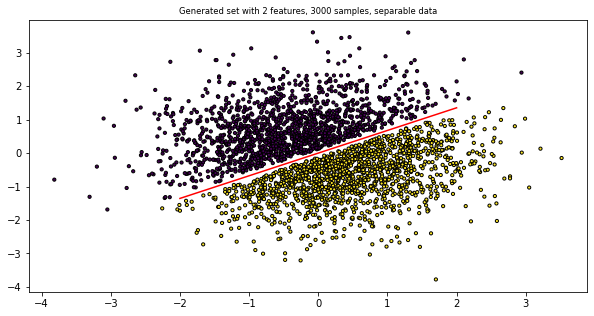

In [9]:
plt.figure(figsize=(10, 5))
plt.title("Generated set with 2 features, 3000 samples, separable data", fontsize="small")
x_3000, y_3000, v_normal = make_classification_normal(2, 3000, rho=0.1)
draw_data_by_coord01(x_3000, y_3000, v_normal)

In [10]:
REPEAT_COUNT = 5
TEST_SIZE = 1/3

losses3000L, losses3000J, rads3000, X_trains3000, y_trains3000, mgns3000L, mgns3000J, errs3000L, errs3000J = \
    params2classifiers_for_data(x_3000, y_3000, repeat_count = REPEAT_COUNT, test_size = TEST_SIZE)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]


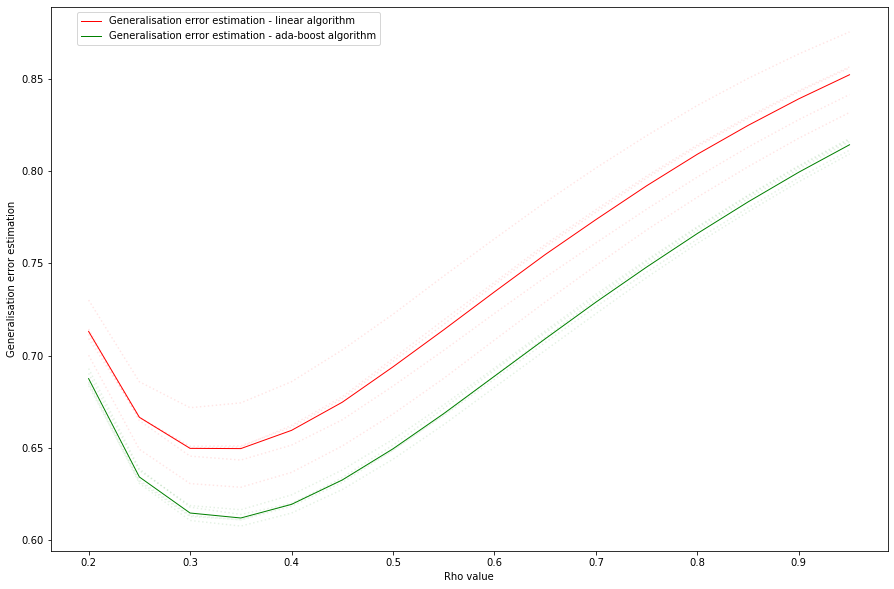

In [23]:
plt.figure(figsize=(15,10))
idxs = np.arange(20, 100, 5)
draw2classifiers_error_bound(X_trains3000, y_trains3000, losses3000L, losses3000J, rads3000, idxs)

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20006.22it/s]


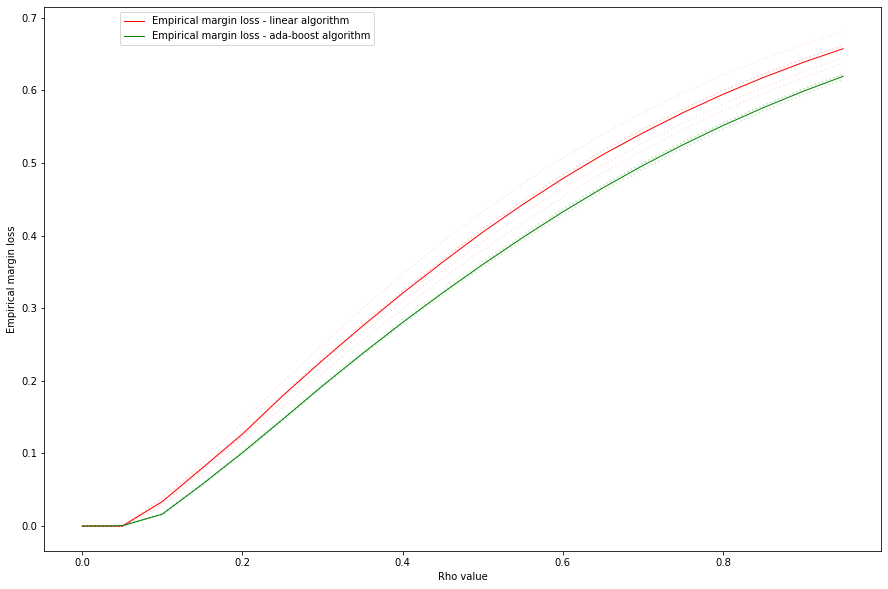

In [28]:
plt.figure(figsize=(15,10))
idxs = np.arange(0, 100, 5)
draw2classifiers_margin_loss(X_trains3000, y_trains3000, losses3000L, losses3000J, idxs)

In [29]:
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(REPEAT_COUNT))
print("Emperical error for linear algorithm: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(errs3000L), np.std(errs3000L)))
print("Emperical error for ada boost algorithm: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(errs3000J), np.std(errs3000J)))
print("Geometric margin for linear algorithm: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(mgns3000L), np.std(mgns3000L)))
print("Geometric margin for ada boost algorithm: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(mgns3000J), np.std(mgns3000J)))
print("Rademacher emperical complexity calculated: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(rads3000), np.std(rads3000)))

IN A SERIES OF TESTS OF 5 EXPERIMENTS:
Emperical error for linear algorithm: average-0.0048, std. deviation-0.0021
Emperical error for ada boost algorithm: average-0.0034, std. deviation-0.0025
Geometric margin for linear algorithm: average-0.0651, std. deviation-0.0031
Geometric margin for ada boost algorithm: average-0.0293, std. deviation-0.0061
Rademacher emperical complexity calculated: average-0.0495, std. deviation-0.0003


### 2. Separable normaly distributed data, 2 features, 10000 samples

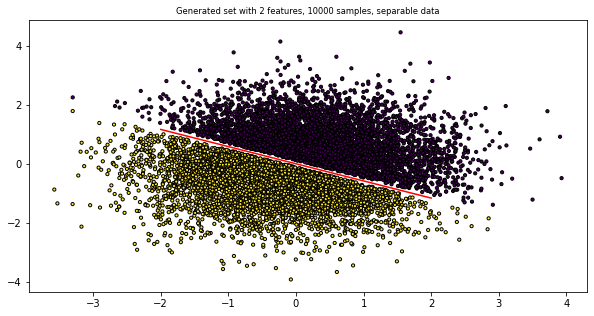

In [30]:
plt.figure(figsize=(10, 5))
plt.title("Generated set with 2 features, 10000 samples, separable data", fontsize="small")
x_10000, y_10000, v_normal = make_classification_normal(2, 10000, rho=0.1)
draw_data_by_coord01(x_10000, y_10000, v_normal)

In [31]:
REPEAT_COUNT = 3
TEST_SIZE = 1/3

losses10000L, losses10000J, rads10000, X_trains10000, y_trains10000, mgns10000L, mgns10000J, errs10000L, err10000J = \
    params2classifiers_for_data(x_10000, y_10000, repeat_count = REPEAT_COUNT, test_size = TEST_SIZE)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<?, ?it/s]


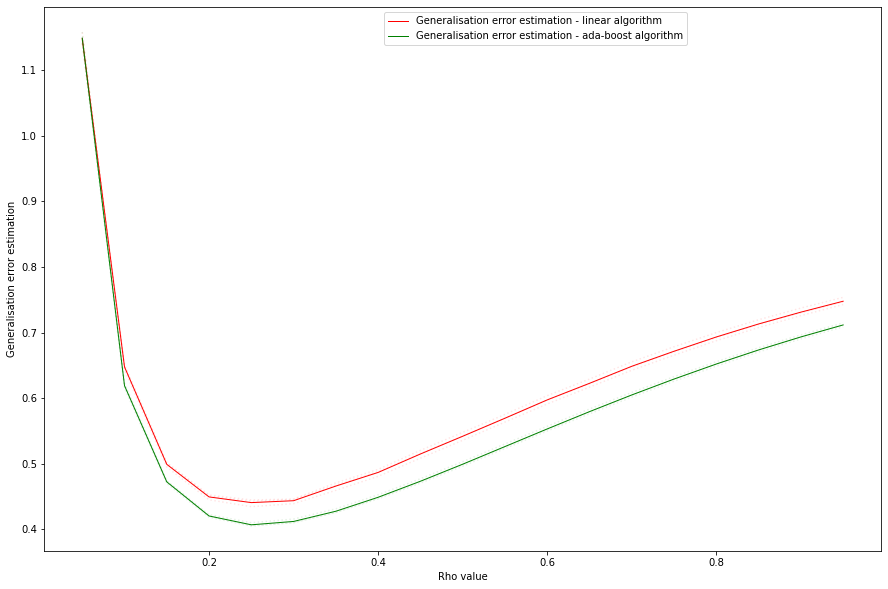

In [32]:
plt.figure(figsize=(15,10))
idxs = np.arange(5, 100, 5)
draw2classifiers_error_bound(X_trains10000, y_trains10000, losses10000L, losses10000J, rads10000, idxs)

Exception ignored in: <function tqdm.__del__ at 0x000001972357C790>
Traceback (most recent call last):
  File "d:\Programs-python\anaconda3\lib\site-packages\tqdm\std.py", line 1147, in __del__
    self.close()
  File "d:\Programs-python\anaconda3\lib\site-packages\tqdm\std.py", line 1266, in close
    if self.disable:
AttributeError: 'tqdm' object has no attribute 'disable'
100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20010.99it/s]


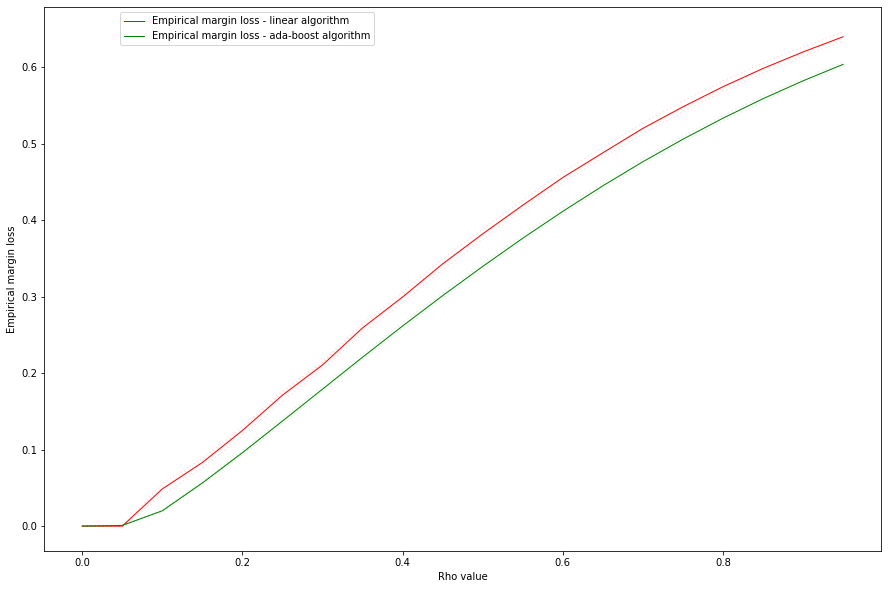

In [33]:
plt.figure(figsize=(15,10))
idxs = np.arange(0, 100, 5)
draw2classifiers_margin_loss(X_trains10000, y_trains10000, losses10000L, losses10000J, idxs)

In [34]:
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(REPEAT_COUNT))
print("Emperical error for linear algorithm: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(errs10000L), np.std(errs10000L)))
print("Emperical error for ada boost algorithm: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(err10000J), np.std(err10000J)))
print("Geometric margin for linear algorithm: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(mgns10000L), np.std(mgns10000L)))
print("Geometric margin for ada boost algorithm: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(mgns10000J), np.std(mgns10000J)))
print("Rademacher emperical complexity calculated: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(rads10000), np.std(rads10000)))

IN A SERIES OF TESTS OF 3 EXPERIMENTS:
Emperical error for linear algorithm: average-0.0043, std. deviation-0.0003
Emperical error for ada boost algorithm: average-0.0013, std. deviation-0.0008
Geometric margin for linear algorithm: average-0.0588, std. deviation-0.0000
Geometric margin for ada boost algorithm: average-0.0040, std. deviation-0.0013
Rademacher emperical complexity calculated: average-0.0275, std. deviation-0.0002


### 3. Separable data with 5 features and 3000 samples

In [35]:
REPEAT_COUNT = 3
TEST_SIZE = 1/3

X_data3000_2, _ = make_classification(n_samples=3000, n_features=5, n_informative=2\
                                , n_redundant=2, n_clusters_per_class=2, shuffle=False)
X_data3000_2, y_data3000_2, _ = make_separable_labels(X_data3000_2, rho=0.1)
losses3000_2L, losses3000_2J, rads3000_2, X_trains3000_2, y_trains3000_2, mgns3000_2L, mgns3000_2J, errs3000_2L, errs3000_2J = \
    params2classifiers_for_data(X_data3000_2, y_data3000_2, repeat_count = REPEAT_COUNT, test_size = TEST_SIZE)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<?, ?it/s]


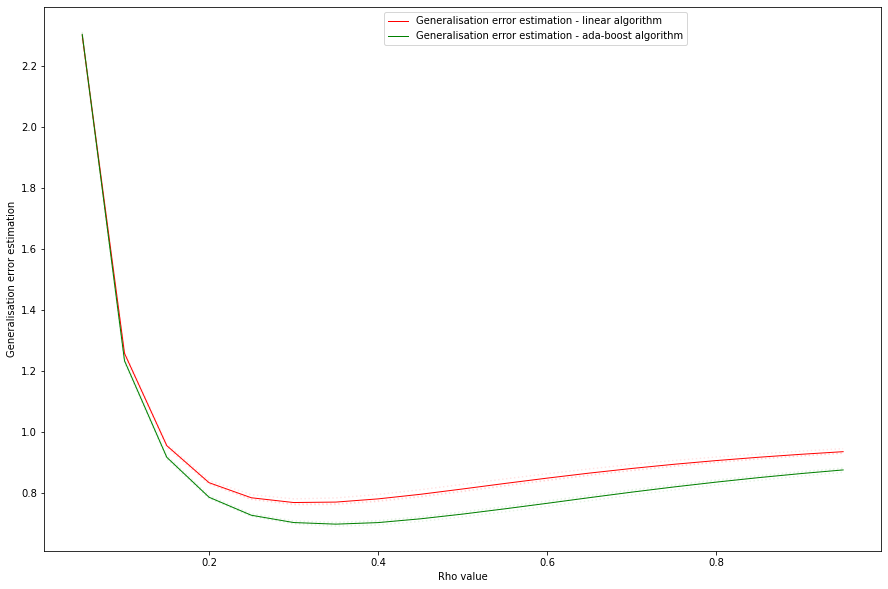

In [36]:
plt.figure(figsize=(15,10))
idxs = np.arange(5, 100, 5)
draw2classifiers_error_bound(X_trains3000_2, y_trains3000_2, losses3000_2L, losses3000_2J, rads3000_2, idxs)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]


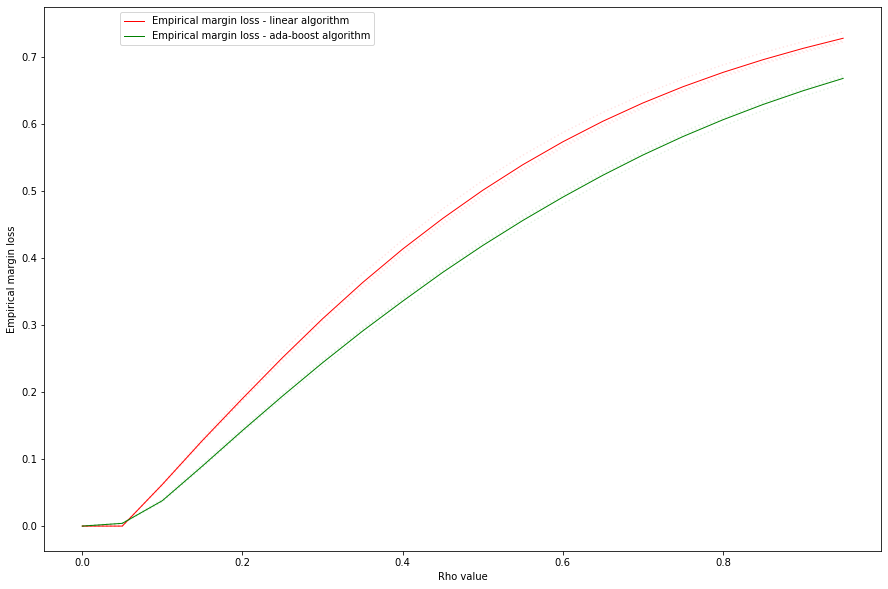

In [37]:
plt.figure(figsize=(15,10))
idxs = np.arange(0, 100, 5)
draw2classifiers_margin_loss(X_trains3000_2, y_trains3000_2, losses3000_2L, losses3000_2J, idxs)

In [38]:
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(REPEAT_COUNT))
print("Emperical error for linear algorithm: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(errs3000_2L), np.std(errs3000_2L)))
print("Emperical error for ada boost algorithm: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(errs3000_2J), np.std(errs3000_2J)))
print("Geometric margin for linear algorithm: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(mgns3000_2L), np.std(mgns3000_2L)))
print("Geometric margin for ada boost algorithm: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(mgns3000_2J), np.std(mgns3000_2J)))
print("Rademacher emperical complexity calculated: average-{:1.4f}, std. deviation-{:1.4f}"\
      .format(np.average(rads3000_2), np.std(rads3000_2)))

IN A SERIES OF TESTS OF 3 EXPERIMENTS:
Emperical error for linear algorithm: average-0.0027, std. deviation-0.0005
Emperical error for ada boost algorithm: average-0.0060, std. deviation-0.0000
Geometric margin for linear algorithm: average-0.0526, std. deviation-0.0007
Geometric margin for ada boost algorithm: average-0.0197, std. deviation-0.0041
Rademacher emperical complexity calculated: average-0.0552, std. deviation-0.0002


### 4. Breast cancer data set

In [39]:
df = pd.read_csv(base_path+'/data/breast-cancer/breast-cancer-wisconsin.data', header=None)
df.fillna(0, inplace=True)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [40]:
REPEAT_COUNT = 10
TEST_SIZE = 1/4

raw = df.to_numpy(copy=True)
x_bc = raw[:, 1:10]
y_bc = raw[:, 10].astype(int) - 3
losses_bcL, losses_bcJ, rads_bc, X_trains_bc, y_trains_bc, mgns_bcL, mgns_bcJ, errs_bcL, err_bcJ = \
    params2classifiers_for_data(x_bc, y_bc, repeat_count = REPEAT_COUNT, test_size = TEST_SIZE)

Error diring calculation: ('Failed to separate in ada boost algorithm, accuracy = 0.9942748091603053',)
Iteration skipped
Error diring calculation: ('Failed to separate in ada boost algorithm, accuracy = 0.9866412213740458',)
Iteration skipped
Error diring calculation: ('Failed to separate in ada boost algorithm, accuracy = 0.9923664122137404',)
Iteration skipped
Error diring calculation: ('Failed to separate in ada boost algorithm, accuracy = 0.9961832061068703',)
Iteration skipped
Error diring calculation: ('Failed to separate in ada boost algorithm, accuracy = 0.9961832061068703',)
Iteration skipped
Error diring calculation: ('Failed to separate in ada boost algorithm, accuracy = 0.9866412213740458',)
Iteration skipped
Error diring calculation: ('Failed to separate in ada boost algorithm, accuracy = 0.9923664122137404',)
Iteration skipped
Error diring calculation: ('Failed to separate in ada boost algorithm, accuracy = 0.9980916030534351',)
Iteration skipped
Error diring calculation

100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 18938.16it/s]


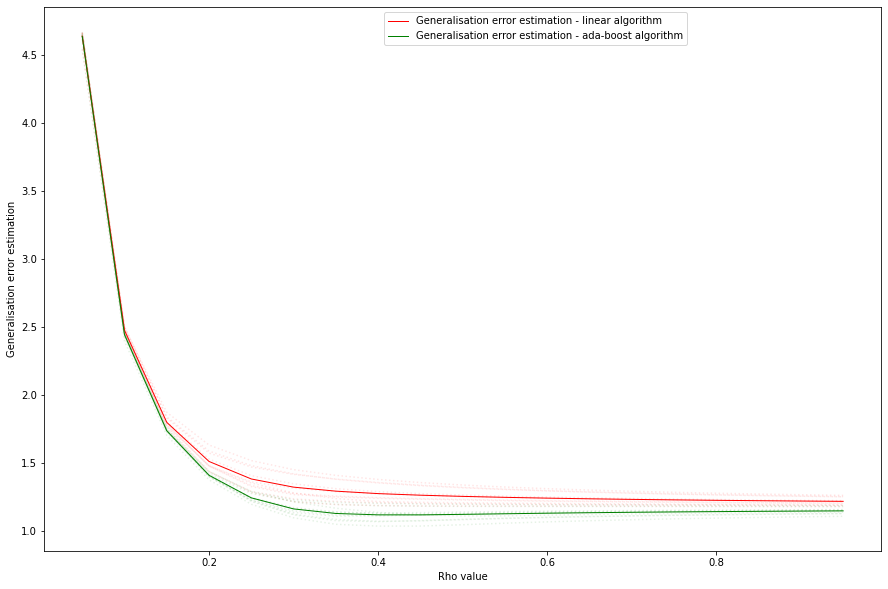

In [41]:
plt.figure(figsize=(15,10))
idxs = np.arange(5, 100, 5)
draw2classifiers_error_bound(X_trains_bc, y_trains_bc, losses_bcL, losses_bcJ, rads_bc, idxs)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]


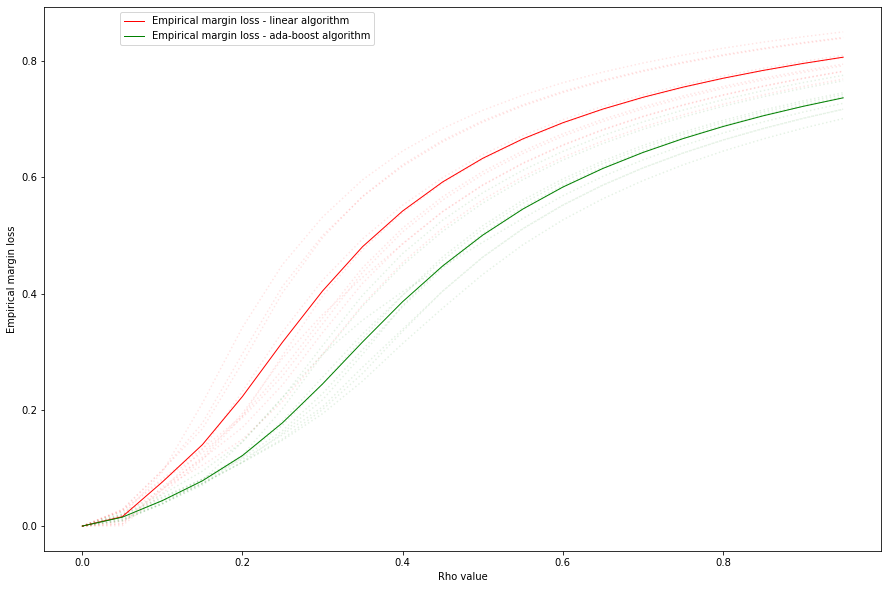

In [42]:
plt.figure(figsize=(15,10))
idxs = np.arange(0, 100, 5)
draw2classifiers_margin_loss(X_trains_bc, y_trains_bc, losses_bcL, losses_bcJ, idxs)

### 5. Ionosphere data set

In [43]:
df = pd.read_csv(base_path+'/data/ionosphere/ionosphere.data', header=None)
df['decoded'] = df[34].apply(lambda x: -1 if x == 'b' else 1)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,decoded
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b,-1
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g,1
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b,-1
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g,1


In [46]:
REPEAT_COUNT = 10
TEST_SIZE = 1/4

raw = df.copy(True)
y_data_df = raw['decoded']
x_data_df = raw.drop([34, 'decoded'], axis = 1)
y_iono = y_data_df.to_numpy(copy=True)
x_iono = x_data_df.to_numpy(copy=True)
losses_ionoL, losses_ionoJ, rads_iono, X_trains_iono, y_trains_iono, mgns_ionoL, mgns_ionoJ, errs_ionoL, err_ionoJ = \
    params2classifiers_for_data(x_iono, y_iono, repeat_count = REPEAT_COUNT, test_size = TEST_SIZE)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<?, ?it/s]


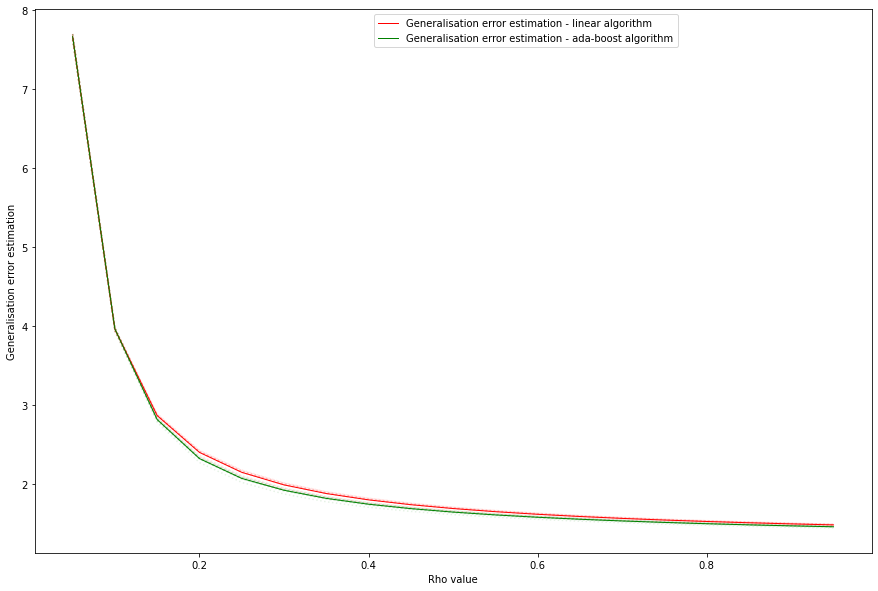

In [47]:
plt.figure(figsize=(15,10))
idxs = np.arange(5, 100, 5)
draw2classifiers_error_bound(X_trains_iono, y_trains_iono, losses_ionoL, losses_ionoJ, rads_iono, idxs)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]


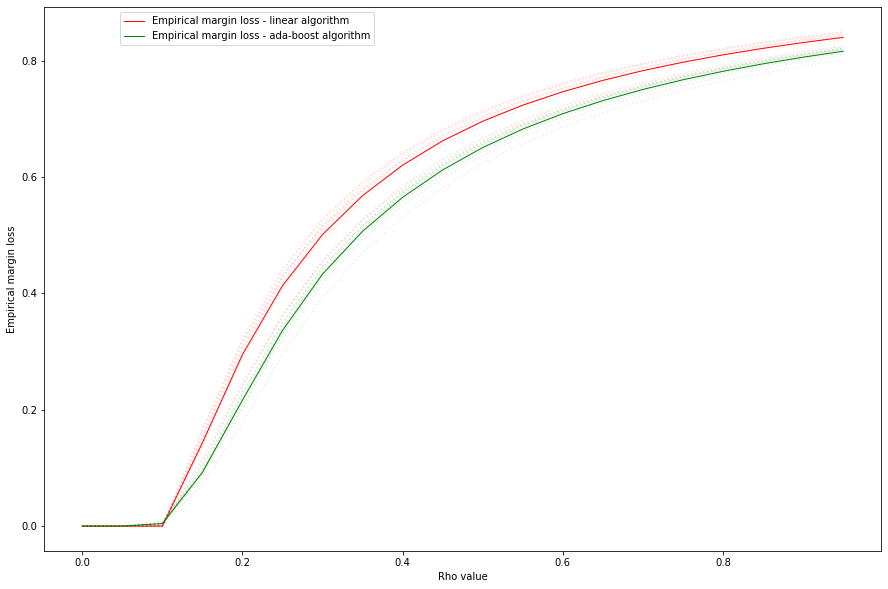

In [48]:
plt.figure(figsize=(15,10))
idxs = np.arange(0, 100, 5)
draw2classifiers_margin_loss(X_trains_iono, y_trains_iono, losses_ionoL, losses_ionoJ, idxs)